In [65]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path
from skimage.io import imread
import cv2
import skimage
import skimage.morphology
import re

Rode a célula abaixo (mude para "Code", por enquanto está "Raw") para capturar imagens.

# Projeto: Pedra-Papel-Tesoura

Neste projeto vocês devem construir um sistema que captura uma imagem da camera e diz se a imagem representa uma jogada de pedra, papel ou tesoura.

Projeto em duplas.

Entregável: Jupyter Notebook com a demonstração do sistema funcionando, e arquivo '.joblib' com o modelo treinado.

Entrega: 9/10, 23:59

Rubrica:

- I - Não entregou ou entregou nonsense.
- C - Funciona, mas com bugs menores.
- A - Funciona bem.

(480, 640)


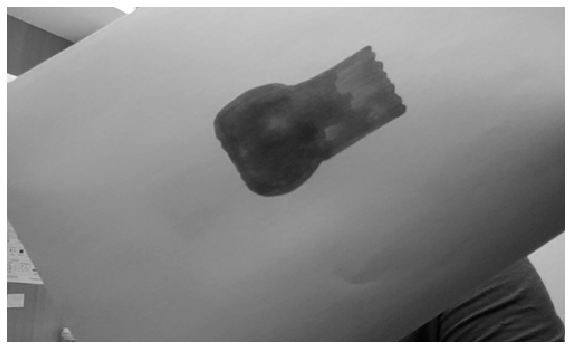

In [66]:
image = os.path.join(os.getcwd(), "RPS/pedra-1.png")
image = skimage.io.imread(image, as_gray=True)

def ski_plot(img):

    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.show()

print(image.shape)    
image = image[100:400,100:600]
ski_plot(image)

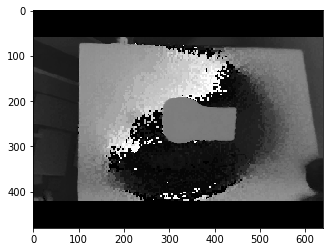

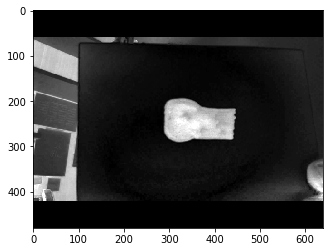

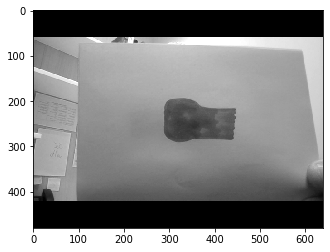

In [67]:

from skimage import io
from skimage.color import rgb2hsv

play = rgb2hsv(io.imread("RPS/pedra-0.png"))
plt.figure()
plt.imshow(play[:,:,0], cmap="gray")
plt.figure()
plt.imshow(play[:,:,1], cmap="gray")
plt.figure()
plt.imshow(play[:,:,2], cmap="gray")
img = play[:,:,1]
plt.show()

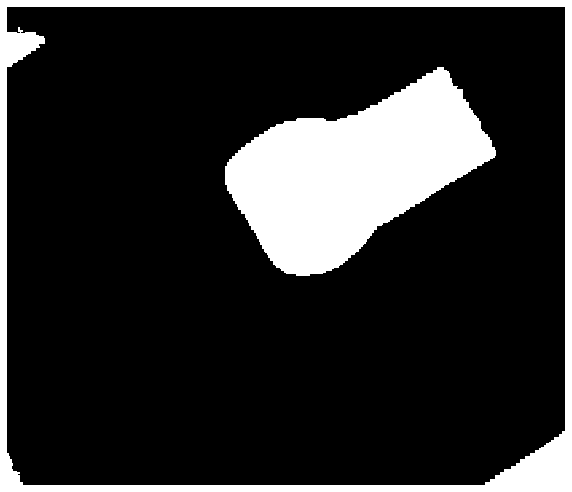

In [68]:
play = rgb2hsv(io.imread("RPS/pedra-1.png"))
img = play[:,:,1]
img_cut = img[100:400,150:500]
img_the = (img_cut>0.4) & (img_cut<1.1)
ski_plot(img_the)

In [69]:
x,y = img_the.shape
reco = np.zeros(img_the.shape)
reco[(x//2),(y//2)] =1


In [70]:
print(reco.max())

1.0


In [71]:

a = skimage.morphology.reconstruction(reco,img_the.astype(np.uint8))

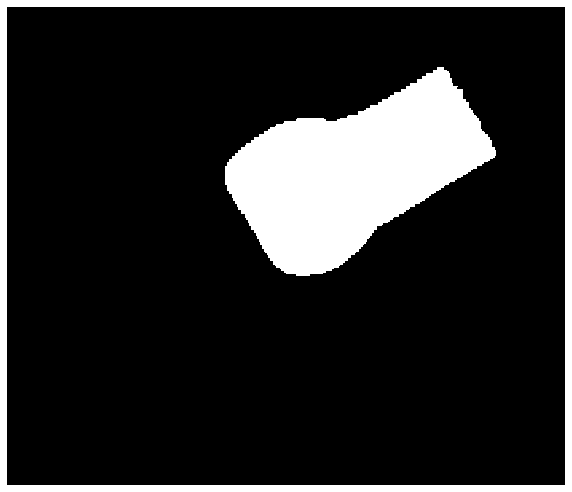

In [72]:
ski_plot(a)

In [73]:
def read_images():
    data_dir = os.path.join(os.getcwd(), 'RPS')
    searcher = re.compile(r'^(.*)-(\d{1,2})\.png$')
    imgs = {}
    for name in os.listdir(data_dir):
        match = searcher.search(name)
        cat = match.group(1)
        num = int(match.group(2))
        img = imread(os.path.join(data_dir, name))
        
        #morfology
        play = rgb2hsv(io.imread(os.path.join(data_dir, name)))
        img = play[:,:,1]
        img = img[100:400,150:500]
        img = (img>0.4) & (img<1.1)
        
        x,y = img_the.shape
        reco = np.zeros(img.shape)
        reco[(x//2),(y//2)] =1        
        img = skimage.morphology.reconstruction(reco,img.astype(np.uint8))
        
        #debug
        #print(os.path.join(data_dir, name))
        #plt.imshow(img, cmap='gray')
        #plt.show()
        
        
        if not cat in imgs:
            imgs[cat] = []
        imgs[cat].append(img)
    return imgs

imgs_per_cat = read_images()

pedra: 4 images


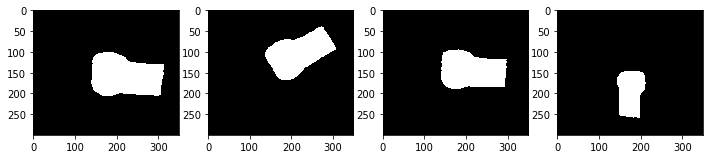

papel: 8 images


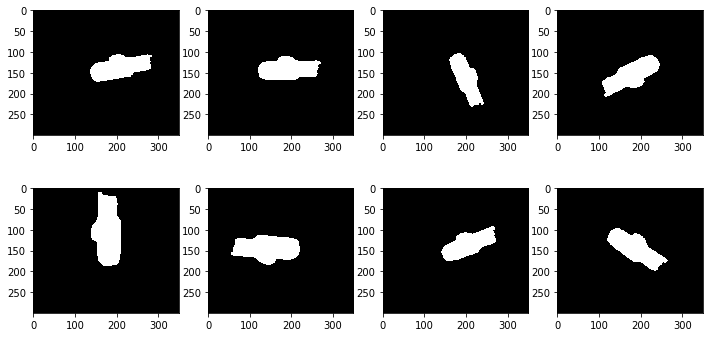

tesoura: 7 images


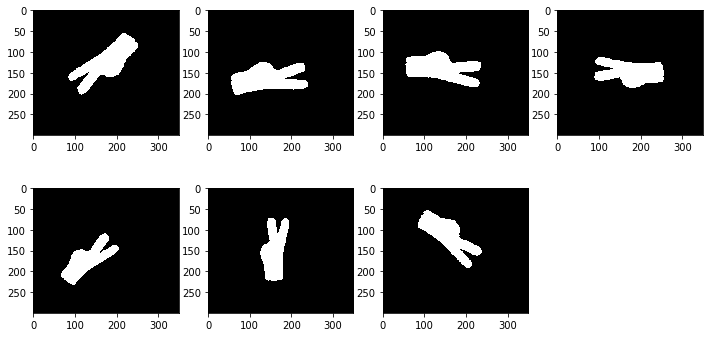

In [74]:
def show_images(imgs):
    C = 4
    N = len(imgs)
    R = (N - 1)//C + 1
    
    plt.figure(figsize=(C*3, R*3))
    for k, img in enumerate(imgs):
        plt.subplot(R, C, k+1)
        plt.imshow(img, cmap='gray')
    plt.show()

for cat, imgs in imgs_per_cat.items():
    print(f'{cat}: {len(imgs)} images')
    show_images(imgs)

In [75]:
from skimage.measure import regionprops, perimeter

X = []
y = []

for cat, imgs in imgs_per_cat.items():
    for img in imgs:
        props = regionprops(img.astype(np.int8))[0] #mudei isso
        eccentricity = props['eccentricity']
        hu_moments = props['moments_hu']
        area = props['area']
        perimeter = props['perimeter']
        if perimeter == 0.0:
            perimeter = 1.0
        compactness = 4.0*np.pi*area/perimeter
        feats = [eccentricity, compactness] + list(hu_moments)
        X.append(feats)
        y.append(cat)

/home/formulos/.local/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/formulos/.local/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


In [92]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [93]:
y_test

['pedra', 'papel', 'tesoura', 'papel', 'tesoura']

In [94]:
len(X_train)

14

In [95]:
clf = RandomForestClassifier(n_estimators=100)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

1.0

In [96]:
# Salvando o modelo
import joblib

joblib.dump(clf, 'modelo.joblib')

['modelo.joblib']

In [97]:
# Lendo o modelo.
clf = joblib.load('modelo.joblib')

In [98]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

print(confusion_matrix(y_test, y_pred))

[[2 0 0]
 [0 1 0]
 [0 0 2]]


Confusion matrix, without normalization
[[2 0 0]
 [0 1 0]
 [0 0 2]]


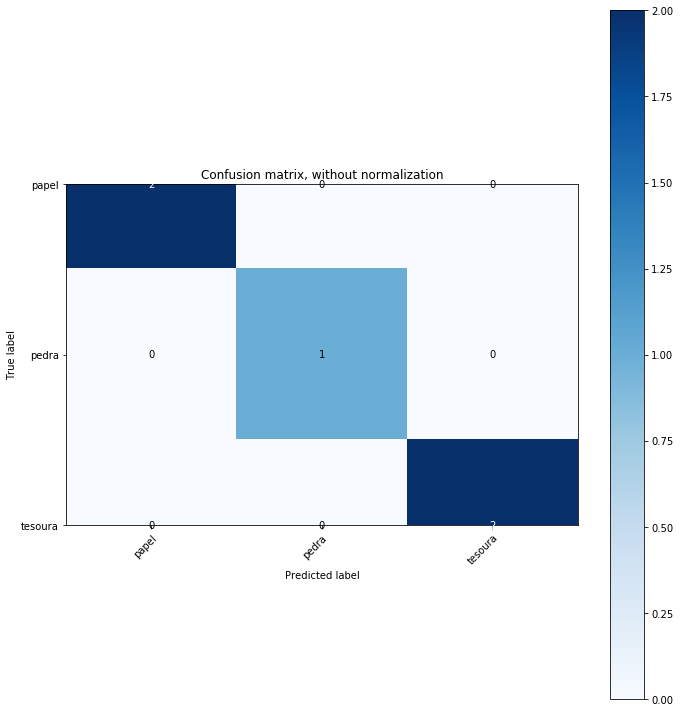

In [99]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=clf.classes_, normalize=False,
                      title='Confusion matrix, without normalization')

plt.show()